In [3]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../flood_prediction') # going to the parent folder of the current folder
from data_prep import get_data_and_targets

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf

# Getting data from API (data_prep.py)

In [4]:
df = get_data_and_targets()

In [5]:
df.shape

(347709, 11)

In [6]:
df.tail(5)

,date,T(degC),rain(mm),surf_press(hPa),wind_s(km/h),wind_dir(deg),soil_moist_0_to_7cm(m3),soil_moist_7_to_28cm(m3),radiation(W/m2),river_discharge(m3/s),target
347704,2023-08-31 16:00:00,20.6,0.0,981.4,10.5,221.0,0.413,0.432,646.0,43.87,0
347705,2023-08-31 17:00:00,19.9,0.0,981.6,11.7,223.0,0.412,0.432,509.0,43.87,0
347706,2023-08-31 18:00:00,18.9,0.0,981.9,8.5,208.0,0.411,0.431,324.0,43.87,0
347707,2023-08-31 19:00:00,17.6,0.0,981.1,5.4,200.0,0.411,0.431,121.0,43.87,0
347708,2023-08-31 20:00:00,16.8,0.0,981.3,3.9,214.0,0.411,0.431,6.0,43.87,0


In [7]:
df.drop(columns='target', inplace=True)
df.shape

(347709, 10)

# Feature Engineering

In [8]:
# Convert degrees to radians and store the values into wd_rad
wd_rad = df.pop('wind_dir(deg)')*np.pi / 180

# Calculate the wind x and y components and store then in two new columns
# `Wx` and `Wy`
wv = df.pop('wind_s(km/h)')
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)


In [9]:
# Similarly to the wind direction, the time in seconds is not a useful model input
# The weather dataset has clear daily and yearly periodicities
# Using sine and cosine functions, we can compute:
# - the time of the day
# - the time of the year

# Collecting the timestamps
datetime_df = pd.to_datetime(df.pop('date'), format='%Y-%m-%d %H:%M:%S')
timestamps_s =  datetime_df.map(pd.Timestamp.timestamp)
timestamps_s

# 24 hours x 60 minutes/hour x 60 seconds/minute
day = 24*60*60 

# 1 month in days
month = (365.2425/12)*day

# 1 year in days
year = (365.2425)*day

# Day periodicity
df['day_sin'] = np.sin(timestamps_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamps_s * (2 * np.pi / day))

# Month periodicity
df['month_sin'] = np.sin(timestamps_s * (2 * np.pi / month))
df['month_cos'] = np.cos(timestamps_s * (2 * np.pi / month))

# Year periodicity
df['year_sin'] = np.sin(timestamps_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamps_s * (2 * np.pi / year))

In [21]:
df.head()

,T(degC),rain(mm),surf_press(hPa),soil_moist_0_to_7cm(m3),soil_moist_7_to_28cm(m3),radiation(W/m2),river_discharge(m3/s),Wx,Wy,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos
0,19.2,0.0,982.1,0.251,0.278,0.0,48.77,3.935789,-2.181643,-2.239978e-12,1.000000,-0.081451,0.996677,-0.006795,0.999977
1,19.1,0.0,981.9,0.251,0.278,0.0,48.77,3.935789,-2.181643,2.588190e-01,0.965926,-0.072875,0.997341,-0.006078,0.999982
2,18.6,0.0,982.0,0.251,0.278,0.0,48.77,3.960296,-1.061158,5.000000e-01,0.866025,-0.064294,0.997931,-0.005362,0.999986
3,18.2,0.0,981.9,0.251,0.278,0.0,48.77,3.580279,0.376302,7.071068e-01,0.707107,-0.055708,0.998447,-0.004645,0.999989
4,17.7,0.0,981.9,0.251,0.278,0.0,48.77,3.632021,0.705993,8.660254e-01,0.500000,-0.047118,0.998889,-0.003928,0.999992


In [23]:
df.shape

(347709, 15)

# Defining goblal variables of the data set

In [24]:
TARGET = 'river_discharge(m3/s)'

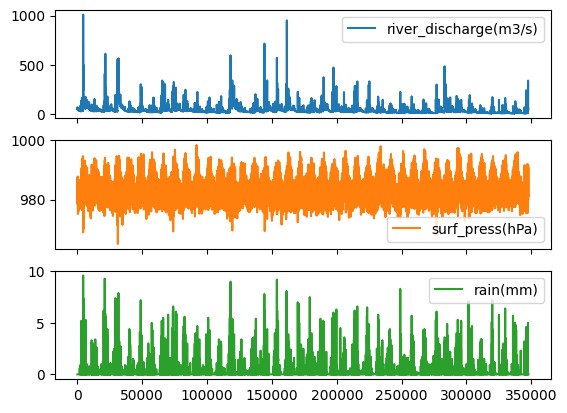

In [25]:
plot_cols = [TARGET, 'surf_press(hPa)', 'rain(mm)']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

In [16]:
DATA = dict(
    length = 347685, # How many timesteps does your dataset contains?
    n_covariates = 8, # number of past covariates, excluding target time series. Our tests do not support future_covariate yet.
    target_column_idx = [0] # List of index(es) of target column(s) in your dataset. e.g [0] for Mono-target problem, e.g. [0,1,4] for multi-variate targets problem. Note that past targets values will also be used as features X.
)

# Creating Folds

### A visual reminder

<hr> 

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/time_series_cross_validation.png" alt="Time Series Cross Validation" width="800">

<hr>

### Defining global variables

In [26]:
# Considering folds of 1 year
FOLD_LENGTH = 24 * 365

# Folds starting every trimester
FOLD_STRIDE = 24 * 91  # 1 quarter = 91 days

# train-test-split ratio of 2/3 
TRAIN_TEST_RATIO = 0.66

### Function to get folds

In [27]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    """    
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Args:
        df (pd.DataFrame): Overall dataframe
        fold_length (int): How long each fold should be in rows
        fold_stride (int): How many timesteps to move forward between taking each fold

    Returns:
        List[pd.DataFrame]: A list where each fold is a dataframe within
    """
 
    
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

In [28]:
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)
print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 156 folds.
Each fold has a shape equal to (8760, 15).


In [29]:
fold = folds[0]
fold

,T(degC),rain(mm),surf_press(hPa),soil_moist_0_to_7cm(m3),soil_moist_7_to_28cm(m3),radiation(W/m2),river_discharge(m3/s),Wx,Wy,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos
0,19.2,0.0,982.1,0.251,0.278,0.0,48.77,3.935789,-2.181643,-2.239978e-12,1.000000,-0.081451,0.996677,-0.006795,0.999977
1,19.1,0.0,981.9,0.251,0.278,0.0,48.77,3.935789,-2.181643,2.588190e-01,0.965926,-0.072875,0.997341,-0.006078,0.999982
2,18.6,0.0,982.0,0.251,0.278,0.0,48.77,3.960296,-1.061158,5.000000e-01,0.866025,-0.064294,0.997931,-0.005362,0.999986
3,18.2,0.0,981.9,0.251,0.278,0.0,48.77,3.580279,0.376302,7.071068e-01,0.707107,-0.055708,0.998447,-0.004645,0.999989
4,17.7,0.0,981.9,0.251,0.278,0.0,48.77,3.632021,0.705993,8.660254e-01,0.500000,-0.047118,0.998889,-0.003928,0.999992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,24.9,0.0,980.7,0.258,0.279,460.0,85.30,-6.478708,-12.184677,-9.659258e-01,0.258819,-0.173722,0.984795,-0.014550,0.999894
8756,23.3,0.0,980.6,0.258,0.279,247.0,85.30,-4.734408,-9.706976,-8.660254e-01,0.500000,-0.165245,0.986252,-0.013833,0.999904
8757,21.5,0.0,980.8,0.258,0.279,55.0,85.30,-1.761397,-5.421022,-7.071068e-01,0.707107,-0.156756,0.987637,-0.013117,0.999914
8758,20.1,0.0,980.8,0.258,0.279,0.0,85.30,-1.427339,-5.724745,-5.000000e-01,0.866025,-0.148255,0.988949,-0.012400,0.999923


# Train/Test split in the fold

### Defining global variables

In [60]:
# Input lenght of 2 week
INPUT_LENGTH = 24 * 14

# Horizon of 1 day
HORIZON = 24

### Defining train/test split function

In [31]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    """From a fold dataframe, take a train dataframe and test dataframe based on 
    the split ratio.
    - df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    - df_test should contain all the timesteps needed to create all (X_test, y_test) tuples

    Args:
        fold (pd.DataFrame): A fold of timesteps
        train_test_ratio (float): The ratio between train and test 0-1
        input_length (int): How long each X_i will be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (fold_train, fold_test)
    """
    
    # TRAIN SET
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]
    

    return (fold_train, fold_test)

### Defining fold train and fold test inside fold

In [32]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [33]:
# INPUT X
print(f'INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH/24)} days')

N_FEATURES = 14
INPUT_LENGTH = 168 timesteps = 7 days


In [34]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')
# we predict only one value ahead of us (1 hour ahead)
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


# Create (X, y) inside each 'split' by random sampling

### Get one sample (Xi, yi)

In [35]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int) -> tuple[pd.DataFrame]:
    """given a fold, it returns one sequence (X_i, y_i) as based on the desired 
    input_length and output_length with the starting point of the sequence being chosen at random based

    Args:
        fold (pd.DataFrame): A single fold
        input_length (int): How long each X_i should be 
        output_length (int): How long each y_i should be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (X_i, y_i)
    """
    
    if fold.isnull().values.any():
        raise ValueError('fold contains NaN values')

    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)

### Get (X, y) from multiple samples

In [36]:
def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int) -> tuple[np.array]:
    """Given a fold generate X and y based on the number of desired sequences 
    of the given input_length and output_length

    Args:
        fold (pd.DataFrame): Fold dataframe
        number_of_sequences (int): The number of X_i and y_i pairs to include
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y):
            X.shape = (n_samples, input_length, n_covariates)
            y.shape =
                (n_samples, output_length, n_targets) if all 3-dimensions are of size > 1
                (n_samples, output_length) if n_targets == 1
                (n_samples, n_targets) if output_length == 1
                (n_samples, ) if both n_targets and lenghts == 1   
    """
  
    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)

### Choosing randomly the number of samples

In [38]:
# Choosing randomly the number of samples
N_TRAIN = 666 # number_of_samples_train
N_TEST =  333 # number_of_samples_test

In [39]:
X_train_rand, y_train_rand = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_rand, y_test_rand = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

In [40]:
print(X_train_rand.shape)
print(y_train_rand.shape)

(666, 168, 15)
(666, 1, 1)


# Create (X, y) insise each 'split' by scanning  chronologically 

### Defininf get strides function

In [65]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, horizon: int, 
    sequence_stride: int) -> tuple[np.array]:
    """slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence

    Args:
        fold (pd.DataFrame): One single fold dataframe
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i
        sequence_stride (int): How many timesteps to take before taking the next X_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length + horizon) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length + horizon - 1:i + input_length + horizon - 1 + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return (np.array(X), np.array(y))

### Defining the "sequence_stride"

In [66]:
# "sequence_stride" = how many timestamps in the future you move between one sample and the other
SEQUENCE_STRIDE = 8

In [43]:
print("FOLD_LENGTH") 
print(f"= {FOLD_LENGTH} timesteps")
print(f"= {int(FOLD_LENGTH/24)} days")
print(f"= {int(FOLD_LENGTH/24/7)} weeks")

FOLD_LENGTH
= 8760 timesteps
= 365 days
= 52 weeks


In [44]:
X_train_ch, y_train_ch = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test_ch, y_test_ch = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train_ch.shape)
print(y_train_ch.shape)

(702, 168, 15)
(702, 1, 1)


# Baseline

### Baseline model that uses the last seen value as y_pred

In [75]:
from tensorflow.keras.layers import Lambda

def init_baseline(horizon: int, output_lenght=1):

    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,1,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

# Modeling

### Defining model functions

In [46]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [73]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import regularizers

def init_model(X_train, y_train):
    
    # Normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # RNN architecture 
    model = models.Sequential()
    
    ## All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          #kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))

    # Hidden Dense Layer that we are regularizing
    reg_l2 = regularizers.L2(0.5)
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=reg_l2))
    model.add(layers.Dropout(rate=0.5))
    
    ## Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # Compiler 
    adam = optimizers.Adam(learning_rate=0.01)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model

In [69]:
from tensorflow import keras
from keras.callbacks import EarlyStopping

def fit_model(model: tf.keras.Model, X_train, y_train, verbose=1) -> tuple[tf.keras.Model, dict]:

 
    es = EarlyStopping(monitor = "val_loss",
                      patience = 3,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

### Training with the whole dataset

In [62]:
print(SEQUENCE_STRIDE)

8


In [71]:
(whole_train, whole_test) = train_test_split(df, TRAIN_TEST_RATIO, INPUT_LENGTH)
X_train_ch, y_train_ch = get_X_y_strides(whole_train, INPUT_LENGTH, OUTPUT_LENGTH, HORIZON, SEQUENCE_STRIDE)

In [74]:
# Initialising the RNN model

model = init_model(X_train_ch, y_train_ch)
model.summary()

# Training
model, history = fit_model(model, X_train_ch, y_train_ch)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, None, 15)         31        
 ion)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 64)                20480     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22,624
Trainable params: 22,593
Non-trainable params: 31
_________________________________________________

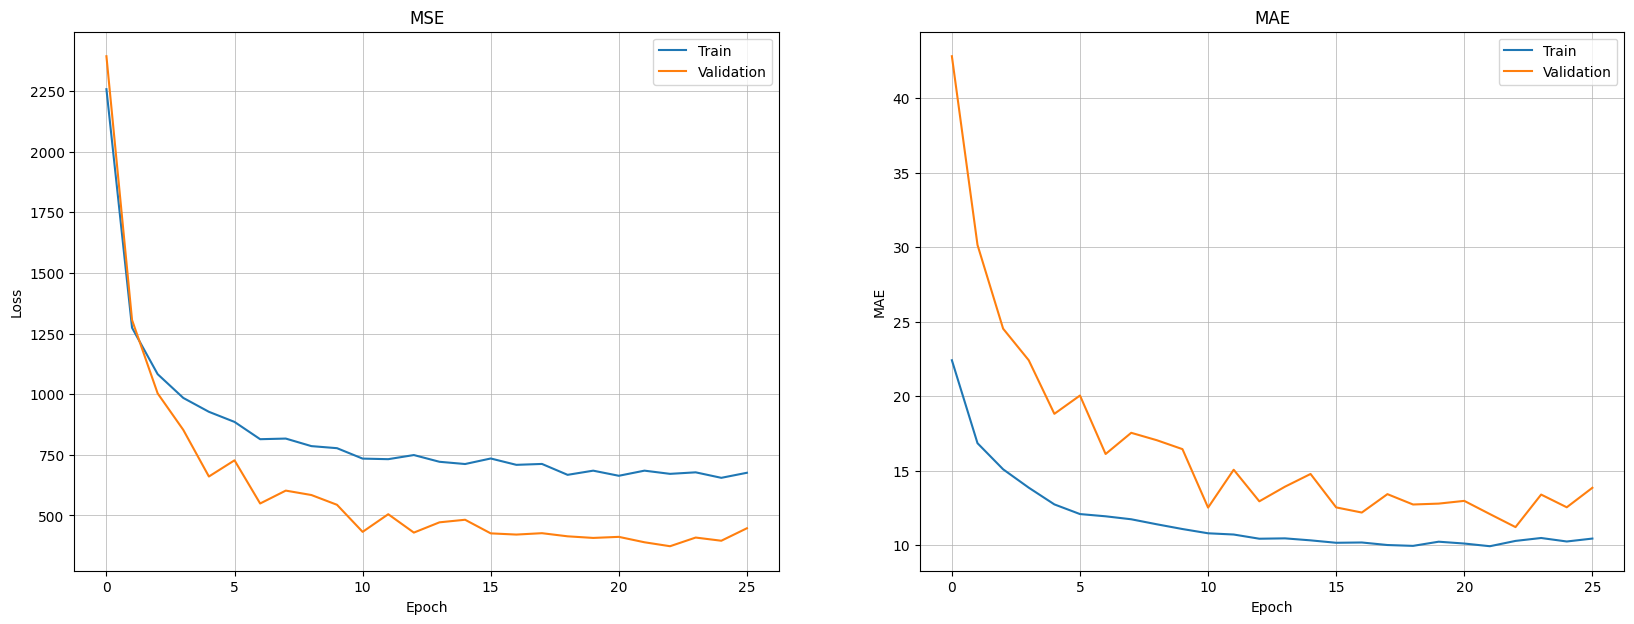

In [76]:
plot_history(history);